In [8]:
!pip install huggingface_hub

In [9]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? [y/N]: y
Token is valid (permission: fineGrained).
The token `token` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate w

In [10]:
!pip install datasets

In [11]:
from datasets import load_dataset
test_dataset = []
test_dataset = load_dataset('KoelLabs/L2Arctic')
test_dataset = test_dataset['scripted']

data/spontaneous-00000-of-00001.parquet:   0%|          | 0.00/50.0M [00:00<?, ?B/s]

data/scripted-00000-of-00001.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

Generating spontaneous split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating scripted split:   0%|          | 0/3599 [00:00<?, ? examples/s]

# Libraries

In [12]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft
from tqdm import tqdm

# EDA

## Test Data from L2-Arctic

In [14]:
# load test-clean data

wav_files_test = []

for sample in test_dataset:
    wav_files_test.append(sample["audio"])

print("Total wav files:", len(wav_files_test))

Total wav files: 3599


- The dataset size is small enough for fast testing, but still enough for a valid evaluation

In [25]:
# Basic Metadata EDA (sample rate, duration, size)

metadata = []

subset = test_dataset.select(range(500))

for sample in tqdm(subset):
    audio = sample["audio"]
    y = audio["array"]
    sr = audio["sampling_rate"]

    duration = len(y) / sr

    size_kb = y.nbytes / 1024

    metadata.append([sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 500/500 [00:06<00:00, 78.85it/s]


,sample_rate,duration_sec,size_kb
0,16000,4.920000,307.500000
1,16000,2.390000,149.375000
2,16000,4.749000,296.812500
3,16000,4.980000,311.250000
4,16000,3.160000,197.500000
5,16000,3.876875,242.304688
6,16000,3.753188,234.574219
7,16000,5.912375,369.523438
8,16000,1.396875,87.304688
9,16000,5.300000,331.250000


- The sample rate 16000 Hz is consistent.
- The duration seems to vary

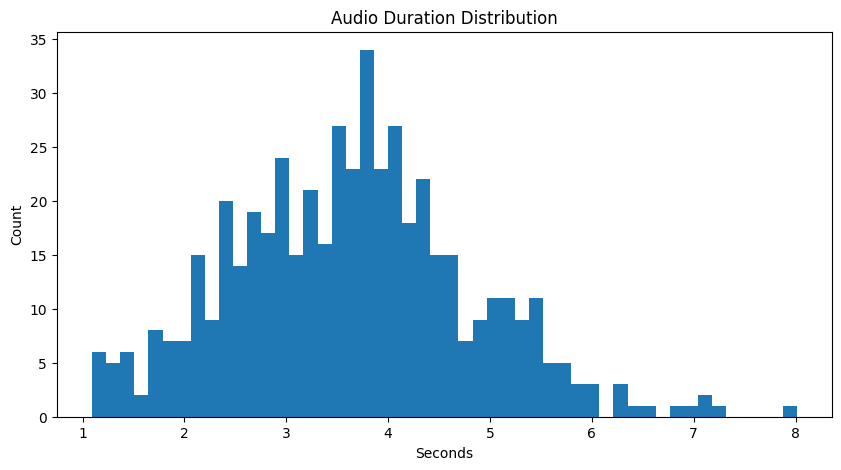

In [23]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- The test set duration distribution is right skewed, with the highest bar at around 3-4 seconds
- The x-axis extends all the way to 8 seconds

100%|██████████| 200/200 [00:02<00:00, 89.26it/s]


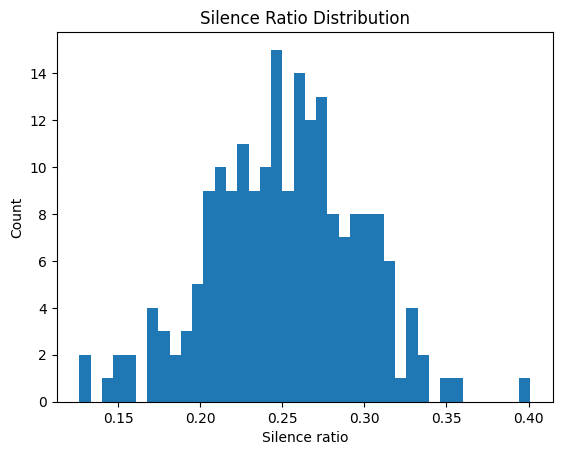

In [26]:
# Silence ratio

def silence_ratio(y, threshold=0.01):
    """
    Input: y is the audio waveform array, threshold defines what amplitude is treated as silence.
    Process: Counts how many samples in y have absolute amplitude below the threshold.
    Output: Returns the proportion of silent samples (0–1) in the audio signal.
    """
    silent = np.sum(np.abs(y) < threshold)
    return silent / len(y)

ratios_test = []

subset = test_dataset.select(range(200))

for sample in tqdm(subset):
    y = sample["audio"]["array"]
    ratios_test.append(silence_ratio(y))

plt.hist(ratios_test, bins=40)
plt.title("Silence Ratio Distribution")
plt.xlabel("Silence ratio")
plt.ylabel("Count")
plt.show()

- The curve is centered around 0.25 (25%)
- Which means the test data is denser and contains more actual speech per second.
- Even though there is a small cluster of files on the far right (around 0.40 silence), it's still more dense than training data

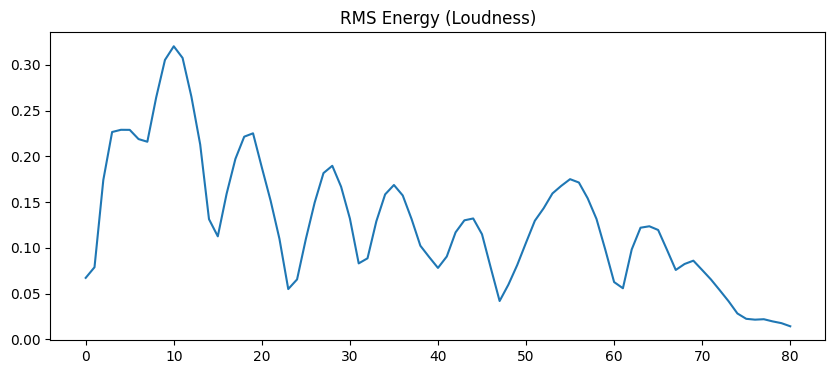

In [37]:
# Amplitude / Loudness (RMS)

rms = librosa.feature.rms(y=y)[0]

plt.figure(figsize=(10,4))
plt.plot(rms)
plt.title("RMS Energy (Loudness)")
plt.show()

- The loudness changes over time, with peaks showing stressed speech and dips showing quieter or silent parts.
- The energy gradually decreases near the end, meaning the speech finishes more softly.
- This up-and-down pattern is typical of read speech with stressed syllables and pauses.

100%|██████████| 200/200 [00:02<00:00, 86.27it/s]


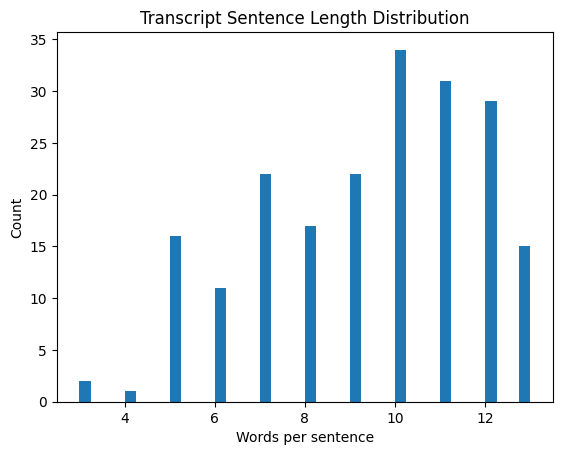

In [38]:
# Transcript EDA (text analysis : counts the number of words per sentence.)

text_col = [c for c in test_dataset.column_names if "text" in c.lower() or "trans" in c.lower()][0]

sent_lengths = []

subset = test_dataset.select(range(200))

for sample in tqdm(subset):
    text = sample[text_col]
    sent_lengths.append(len(text.split()))

plt.hist(sent_lengths, bins=40)
plt.title("Transcript Sentence Length Distribution")
plt.xlabel("Words per sentence")
plt.ylabel("Count")
plt.show()

- The sentence length do not vary much, with the lowest 2 words
- The most often is 10 words

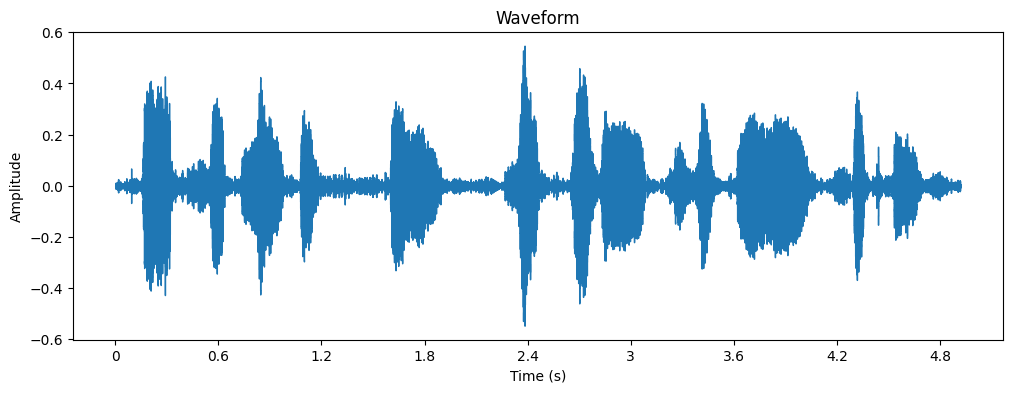

In [39]:
# Waveform Visualization (time domain)

sample = test_dataset[0]

y = sample["audio"]["array"]
sr = sample["audio"]["sampling_rate"]

plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

- The waveform has several loud bursts separated by quieter parts, showing syllables with short pauses typical of speech.
- The biggest peak around 2.4 s likely corresponds to a stressed syllable, while smaller waves between peaks are softer sounds.
- The signal stays centered around zero and doesn't clip, indicating good recording quality and proper normalization.

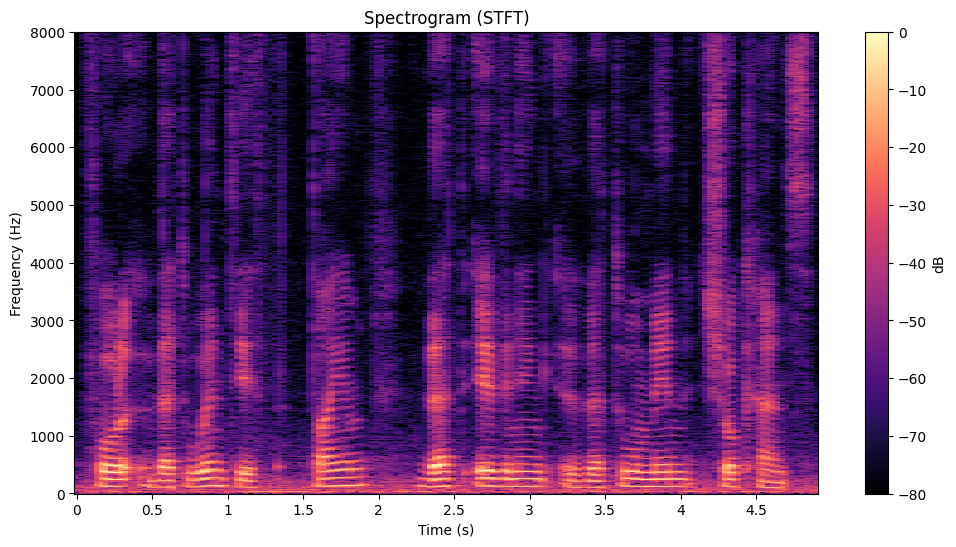

In [40]:
# Short-Time Fourier Transform (STFT) Spectogram

sample = test_dataset[0]

y = sample["audio"]["array"]
sr = sample["audio"]["sampling_rate"]

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(label="dB")
plt.title("Spectrogram (STFT)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

- Most energy is below about 3 kHz with clear horizontal lines, showing voiced speech mainly from vowel sounds.
- Vertical streaks represent consonant bursts, while dark gaps indicate pauses or low-energy parts between syllables.
- The clear structure and low noise suggest clean, well-recorded read speech typical of L2Arctic.

In [35]:
speaker_counts = pd.Series(test_dataset["speaker_code"]).value_counts()
speaker_counts.head(10)

,count
ABA,150
SKA,150
ZHAA,150
BWC,150
NCC,150
LXC,150
TXHC,150
ASI,150
EBVS,150
RRBI,150


- The speakers all have the same consistent count 150